In [34]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline  
import seaborn as sns
from sklearn import preprocessing
import itertools

# Data

In [35]:
# Read all data
all_data_selection = pd.read_csv('fama_french_data.csv', index_col=0, dtype={0:'str'})
all_data_selection.index = pd.to_datetime(all_data_selection.index, format='%Y%m')
X_all = all_data_selection.iloc[:,8:]
#X_all = X_all.drop(columns=['wti_prev_yoy_chg'])
y_SMB_bin = all_data_selection['SMB_bin']
y_HML_bin = all_data_selection['HML_bin']
y_SMB_HML = np.where((all_data_selection['SMB'] - all_data_selection['HML']) >= 0, 1, 0)

In [36]:
# Features for each prediction
#features_SMB = ['Mkt-RF_prev','RF_prev','SMB_prev_month', 'sp500_return_prev_month','TS_Level_Change_prev']
#features_HML = ['HML_prev_month','SMB_prev_year','HML_prev_year','seasoned_corp_bond_yield_prev_month','ttm_pe_previous_month']
#features_SMBHML = ['Mkt-RF_prev','RF_prev','SMB_prev_month', 'HML_prev_month','12m_cpi_forecast']

X_SMB = X_all#.loc[:,features_SMB]
X_HML = X_all#.loc[:,features_HML]
X_SMBHML = X_all#.loc[:,features_SMBHML]

In [37]:
# Normalize all features
scalar_all = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(X_all)
X_all_scaled = scalar_all.transform(X_all)
scalar_SMB = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(X_SMB)
X_SMB_scaled = scalar_SMB.transform(X_SMB)
scalar_HML = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(X_HML)
X_HML_scaled = scalar_HML.transform(X_HML)
scalar_SMBHML = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(X_SMBHML)
X_SMBHML_scaled = scalar_SMBHML.transform(X_SMBHML)

In [38]:
index_names = X_all.index

## Model Definitions and Functions

In [39]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import numpy as np
import math, random

In [40]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, n_classes):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn = nn.GRU(input_size, hidden_size, n_layers, batch_first=True)
    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size)
        out ,_ = self.rnn(x, h0)
        out = out[:,-1,:]
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, n_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size)
        out,_ = self.rnn(x, (h0,c0))
        out = out[:,-1,:]
        return out

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers, n_classes):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first=True)
    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size)
        out,_ = self.rnn(x, h0)
        out = out[:,-1,:]
        return out

In [41]:
def prepare_data(batch_size, sequence_length, predict_window, input_size, series, drop):
    # series must be one of 'SMB', 'HML', 'SMBHML'
    if series == 'SMB':
        X = X_SMB_scaled
        y = y_SMB_bin
    elif series == 'HML':
        X = X_HML_scaled
        y = y_HML_bin
    else:
        X = X_SMBHML_scaled
        y = y_SMB_HML
    if drop > 0:    
        X = X[:-drop,:]
        y = y[:-drop]

    inputs_pd = pd.DataFrame(X[-batch_size-sequence_length-predict_window:,])
    inputs = np.zeros((batch_size+predict_window, sequence_length, input_size))
    for i in range(input_size):
        input_i = inputs_pd.iloc[:,i]
        input_i_s = input_i
        for j in range(1,sequence_length):
            input_i = pd.concat([input_i, input_i_s.shift(-j-1)], axis=1)
        input_i.dropna(axis=0, inplace=True)
        input_i = np.array(input_i)
        inputs[:,:,i] = input_i
    inputs_train = inputs[:-predict_window,:,:]
    inputs_test = inputs[-predict_window:,:,:]
    labels_train = y[-batch_size-predict_window:-predict_window]
    labels_test = y[-predict_window:]
    inputs_train = Variable(torch.Tensor(inputs_train))
    labels_train = Variable(torch.LongTensor(labels_train))
    inputs_test = Variable(torch.Tensor(inputs_test))
    labels_test = Variable(torch.LongTensor(labels_test))
    return inputs_train, labels_train, inputs_test, labels_test

In [42]:
def train_model(seed, modelform, epoch, learning_rate, wd, input_size, hidden_size, num_layers, output_size, inputs, labels):
    if modelform == 'GRU':
        model = GRUModel(input_size, hidden_size, num_layers, output_size)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
    elif modelform == 'LSTM':
        model = LSTMModel(input_size, hidden_size, num_layers, output_size)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
    else:
        model = RNNModel(input_size, hidden_size, num_layers, output_size)
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=wd)
    
    torch.manual_seed(seed)

    loss_pd = pd.DataFrame(columns = range(epoch))
    accuracy_pd = pd.DataFrame(columns = range(epoch))

    for epo in range(epoch):

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, trained = torch.max(outputs.data, 1)
        correct = (trained == labels).sum().item()/batch_size
        loss_pd.loc[modelform,epo] = loss.item()
        accuracy_pd.loc[modelform,epo] = correct
    
    return loss_pd, accuracy_pd, model

In [43]:
def test_model(model, inputs, labels):
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    accuracy = correct/labels.shape[0]
    return predicted, accuracy

In [44]:
def select_features(modelform, epoches, learning_rates, wds, X_train_all, y_train_all):
    #valid_score = pd.DataFrame(index = ['accuracy'])
    #valid_score[:] = 0
    
    for j in range(50,51):#reversed(range(1,51,1)):
        X_train = X_train_all[:-j,:,:]
        X_valid = X_train_all[-j:,:,:]

        y_train = y_train_all[:-j]
        y_valid = y_train_all[-j:]
                
        valid_score_prev = -1
        valid_score = -1
        valid_score_best = -1
        epoch_best = -1
        lr_best = -1
        wd_best = -1
        
        for (epoch, lr, wd) in list(itertools.product(epoches, learning_rates, wds)):
            valid_score_prev = valid_score
            
            loss_train_try, accuracy_train_try, model_try =  train_model(seed, modelform, epoch, lr, wd, input_size, 
                                                                         hidden_size, num_layers, output_size, X_train, y_train)            
            predicted_try, accuracy_valid_try = test_model(model_try, X_valid, y_valid)
            valid_score = accuracy_valid_try
            if valid_score > valid_score_prev:
                valid_score_best = valid_score
                epoch_best = epoch
                lr_best = lr
                wd_best = wd
        
    print('Epoch {:d}, learning rate {:.3f}, weight_decay {:.4f}, validation score {:.4f} '.format(epoch_best, lr_best, wd_best, valid_score_best))
    loss_train, accuracy_train, model =  train_model(seed, modelform, epoch_best, lr_best, wd_best, input_size, 
                                                                 hidden_size, num_layers, output_size, X_train_all, y_train_all)            
    #print('validation error is:', valid_error)
    return epoch_best, lr_best, wd_best, accuracy_train, model

In [45]:
def annual_prediction_model(series, modelform, epoches, learning_rates, wds, batch_size, years):
    test_acc = pd.DataFrame(index = ['Test_accuracy','Epoch','Learning Rate','Weight Decay','Train_accuracy'], 
                            columns = range(1, years+1))
    test_acc[:] = 0
    pred_period = index_names[-years*12:]
    pred_array = np.empty(0)
    for year in reversed(range(1,years+1,1)):
        train_year_end = - 12 * year
        #train_year_beg = - sliding_window + train_year_end
        #X_year = X_all[train_year_beg:,:]
        #y_year = y_all[train_year_beg:]
        
        #X_year_train = X_year[:sliding_window,:] 
        #X_year_test = X_year[sliding_window:sliding_window+12,:]
        
        #y_year_train = y_year[:sliding_window]
        #y_year_test = y_year[sliding_window:sliding_window+12]
        
        X_year_train, y_year_train, X_year_test, y_year_test = \
            prepare_data(batch_size, sequence_length, predict_window, input_size, series, -train_year_end-12)
        
        epoch_best_year, lr_best_year, wd_best_year, accuracy_train_year, model_year = \
            select_features(modelform, epoches, learning_rates, wds, X_year_train, y_year_train)
        predicted_year, accuracy_year = test_model(model_year, X_year_test, y_year_test)
        test_acc.loc['Test_accuracy', year] = accuracy_year
        #print("accuracy_train_year: ", np.array(accuracy_train_year))
        test_acc.loc['Train_accuracy', year] = np.array(accuracy_train_year).flatten()[-1]
        test_acc.loc['Epoch', year] = epoch_best_year
        test_acc.loc['Learning Rate', year] = lr_best_year
        test_acc.loc['Weight Decay', year] = wd_best_year
        pred_array = np.append(pred_array, predicted_year)
    
    pred_array = pred_array.reshape(-1,1)
    predictions = pd.DataFrame(pred_array, index = pred_period, columns = ['Predictions'])
                               
    return test_acc, predictions

## Hyperparameters

In [46]:
num_classes = 2
input_size = 28
hidden_size = 2
output_size = 2
batch_size = 400
sequence_length = 12
num_layers = 1
predict_window = 12
learning_rates = [0.01, 0.015, 0.02, 0.025]
epoches = [500]
wds = [0.001, 0.005, 0.01, 0.02]
seed = 302


## SMB

In [47]:
#test_acc_LSTM_SMB, predictions_LSTM_SMB = annual_prediction_model('SMB', 'LSTM', epoches, learning_rates, wds, batch_size, 30)
test_acc_GRU_SMB, predictions_GRU_SMB = annual_prediction_model('SMB', 'GRU', epoches, learning_rates, wds, batch_size, 30)

Epoch 500, learning rate 0.025, weight_decay 0.0010, validation score 0.6800 
Epoch 500, learning rate 0.025, weight_decay 0.0100, validation score 0.5600 
Epoch 500, learning rate 0.025, weight_decay 0.0100, validation score 0.6000 
Epoch 500, learning rate 0.025, weight_decay 0.0200, validation score 0.6000 
Epoch 500, learning rate 0.025, weight_decay 0.0200, validation score 0.5600 
Epoch 500, learning rate 0.025, weight_decay 0.0010, validation score 0.6800 
Epoch 500, learning rate 0.025, weight_decay 0.0200, validation score 0.5800 
Epoch 500, learning rate 0.025, weight_decay 0.0100, validation score 0.6600 
Epoch 500, learning rate 0.025, weight_decay 0.0200, validation score 0.5400 
Epoch 500, learning rate 0.025, weight_decay 0.0010, validation score 0.6200 
Epoch 500, learning rate 0.025, weight_decay 0.0200, validation score 0.6600 
Epoch 500, learning rate 0.020, weight_decay 0.0200, validation score 0.6000 
Epoch 500, learning rate 0.020, weight_decay 0.0200, validation 

Test_accuracy       0.580556
Epoch             500.000000
Learning Rate       0.024000
Weight Decay        0.011133
Train_accuracy      0.658417
dtype: float64


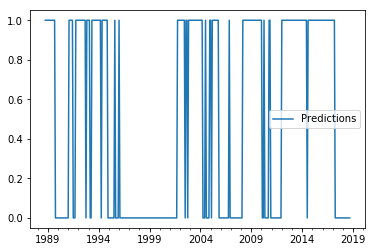

In [48]:
#print(test_acc_LSTM_SMB.T.mean())
print(test_acc_GRU_SMB.T.mean())

#fig, ax = plt.subplots(2,1,figsize=(6,6))
#predictions_LSTM_SMB.plot(ax=ax[0])
predictions_GRU_SMB.plot()

## HML

In [49]:
#test_acc_LSTM_HML, predictions_LSTM_HML = annual_prediction_model('HML', 'LSTM', epoches, learning_rates, wds, batch_size, 30)
test_acc_GRU_HML, predictions_GRU_HML = annual_prediction_model('HML', 'GRU', epoches, learning_rates, wds, batch_size, 30)

Epoch 500, learning rate 0.025, weight_decay 0.0050, validation score 0.5600 
Epoch 500, learning rate 0.025, weight_decay 0.0100, validation score 0.5800 
Epoch 500, learning rate 0.025, weight_decay 0.0050, validation score 0.5600 
Epoch 500, learning rate 0.025, weight_decay 0.0100, validation score 0.4800 
Epoch 500, learning rate 0.020, weight_decay 0.0050, validation score 0.4400 
Epoch 500, learning rate 0.025, weight_decay 0.0100, validation score 0.4400 
Epoch 500, learning rate 0.025, weight_decay 0.0010, validation score 0.5800 
Epoch 500, learning rate 0.025, weight_decay 0.0100, validation score 0.5200 
Epoch 500, learning rate 0.025, weight_decay 0.0010, validation score 0.6400 
Epoch 500, learning rate 0.025, weight_decay 0.0010, validation score 0.5800 
Epoch 500, learning rate 0.025, weight_decay 0.0050, validation score 0.6400 
Epoch 500, learning rate 0.025, weight_decay 0.0100, validation score 0.5200 
Epoch 500, learning rate 0.025, weight_decay 0.0050, validation 

Test_accuracy       0.522222
Epoch             500.000000
Learning Rate       0.024833
Weight Decay        0.009800
Train_accuracy      0.635417
dtype: float64


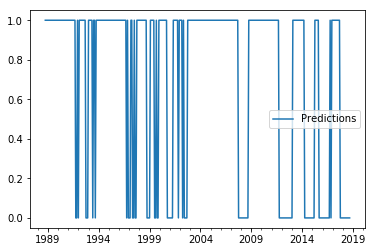

In [50]:
#print(test_acc_LSTM_HML.T.mean())
print(test_acc_GRU_HML.T.mean())

#fig, ax = plt.subplots(2,1,figsize=(6,6))
#predictions_LSTM_HML.plot(ax=ax[0])
predictions_GRU_HML.plot()

## SMB/HML Switch

In [51]:
#test_acc_LSTM_SMBHML, predictions_LSTM_SMBHML = annual_prediction_model('SMBHML', 'LSTM', epoches, learning_rates, wds, batch_size, 30)
test_acc_GRU_SMBHML, predictions_GRU_SMBHML = annual_prediction_model('SMBHML', 'GRU', epoches, learning_rates, wds, batch_size, 30)

Epoch 500, learning rate 0.025, weight_decay 0.0100, validation score 0.6600 
Epoch 500, learning rate 0.025, weight_decay 0.0050, validation score 0.6200 
Epoch 500, learning rate 0.020, weight_decay 0.0050, validation score 0.6200 
Epoch 500, learning rate 0.025, weight_decay 0.0010, validation score 0.5600 
Epoch 500, learning rate 0.025, weight_decay 0.0050, validation score 0.5000 
Epoch 500, learning rate 0.025, weight_decay 0.0100, validation score 0.5400 
Epoch 500, learning rate 0.025, weight_decay 0.0010, validation score 0.5200 
Epoch 500, learning rate 0.025, weight_decay 0.0100, validation score 0.5600 
Epoch 500, learning rate 0.025, weight_decay 0.0200, validation score 0.5400 
Epoch 500, learning rate 0.025, weight_decay 0.0100, validation score 0.6000 
Epoch 500, learning rate 0.025, weight_decay 0.0010, validation score 0.6000 
Epoch 500, learning rate 0.020, weight_decay 0.0050, validation score 0.5400 
Epoch 500, learning rate 0.025, weight_decay 0.0100, validation 

Test_accuracy       0.516667
Epoch             500.000000
Learning Rate       0.024000
Weight Decay        0.009300
Train_accuracy      0.648917
dtype: float64


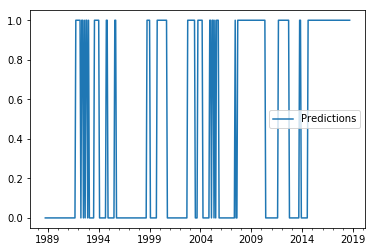

In [52]:
#print(test_acc_LSTM_SMBHML.T.mean())
print(test_acc_GRU_SMBHML.T.mean())

#fig, ax = plt.subplots(2,1,figsize=(6,6))
#predictions_LSTM_SMBHML.plot(ax=ax[0])
predictions_GRU_SMBHML.plot()

# Summarize Results

In [53]:
pred_GRU = predictions_GRU_SMB.merge(predictions_GRU_HML, left_index=True, right_index=True, how='inner')
pred_GRU = pred_GRU.merge(predictions_GRU_SMBHML, left_index=True, right_index=True, how='inner')
pred_GRU.to_csv('../Results/GRU_12_30yr_400window.csv')

In [54]:
test_acc_GRU_SMB.to_csv('../Results/Accuracy/GRU_12_30yr_400window_SMB.csv')
test_acc_GRU_HML.to_csv('../Results/Accuracy/GRU_12_30yr_400window_HML.csv')
test_acc_GRU_SMBHML.to_csv('../Results/Accuracy/GRU_12_30yr_400window_SMBHML.csv')